In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Necessary Imports**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
!pip install optuna


**Data Loading and EDA**

In [ ]:
# ---------------------------------------------------------
# 1. Configuration & Data Loading
# ---------------------------------------------------------
TRAIN_PATH = '/content/drive/MyDrive/ML_Project2/train_dataset.csv'
TEST_PATH = '/content/drive/MyDrive/ML_Project2/test_dataset.csv'

def load_data():
    """Loads train and test CSV files."""
    try:
        train_df = pd.read_csv(TRAIN_PATH)
        test_df = pd.read_csv(TEST_PATH)
        print(f"Loaded Train shape: {train_df.shape}")
        print(f"Loaded Test shape: {test_df.shape}")
        return train_df, test_df
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None, None

In [ ]:
train_df, test_df = load_data()
train_df.head()

Loaded Train shape: (38984, 23)
Loaded Test shape: (16708, 22)


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,...,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,...,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,...,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,...,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,...,47,92,14.9,1,1.2,26,28,15,0,0


In [ ]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobin           38984 non-null 

Data looks categorical or continuous with Numerical mapping already done

There is no null values exist in the dataset for most of the columns


In [ ]:
train_df.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,...,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000
mean,44.127591,164.689488,65.938718,82.062115,1.014955,1.008768,1.025369,1.026190,121.475631,75.994408,...,57.293146,115.081495,14.624264,1.086523,0.886030,26.198235,27.145188,39.905038,0.214421,0.367279
std,12.063564,9.187507,12.896581,9.326798,0.498527,0.493813,0.157246,0.159703,13.643521,9.658734,...,14.617822,42.883163,1.566528,0.402107,0.220621,19.175595,31.309945,49.693843,0.410426,0.482070
min,20.000000,130.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,40.000000,...,4.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,40.000000,160.000000,55.000000,76.000000,0.800000,0.800000,1.000000,1.000000,112.000000,70.000000,...,47.000000,91.000000,13.600000,1.000000,0.800000,19.000000,15.000000,17.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,82.000000,1.000000,1.000000,1.000000,1.000000,120.000000,76.000000,...,55.000000,113.000000,14.800000,1.000000,0.900000,23.000000,21.000000,26.000000,0.000000,0.000000
75%,55.000000,170.000000,75.000000,88.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,...,66.000000,136.000000,15.800000,1.000000,1.000000,29.000000,31.000000,44.000000,0.000000,1.000000
max,85.000000,190.000000,135.000000,129.000000,9.900000,9.900000,2.000000,2.000000,233.000000,146.000000,...,359.000000,1860.000000,21.100000,6.000000,11.600000,1090.000000,2914.000000,999.000000,1.000000,1.000000


In [ ]:
train_df.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [ ]:
train_df.shape


(38984, 23)

In [ ]:
for i in train_df.columns:
  if(train_df[i].dtype==np.int64):
    print(f"Column {i}")
    print(train_df[i].unique())
    print(train_df[i].nunique())
    print("***************************************************************")

Column age
[35 20 45 60 40 50 75 55 25 30 70 65 80 85]
14
***************************************************************
Column height(cm)
[170 175 155 165 160 180 150 140 145 185 190 135 130]
13
***************************************************************
Column weight(kg)
[ 85 110  65  80  60  50  90  75  55  40  70  95  45 100  35 105 115 120
  30 130 125 135]
22
***************************************************************
Column hearing(left)
[1 2]
2
***************************************************************
Column hearing(right)
[1 2]
2
***************************************************************
Column systolic
[118 119 110 158 109 126 130  89 114 112 125 101 127 120 151 100 128 115
 121 116 124 139 102 122 117 165 166 135 148 113 134 106 143 105 129 108
 150 123  98 132 160 155 133 104 180 138  90 107  93  96 169 136 103 137
  95  99 111 141 140 142 154 203 131 144 159 152  92 145 153 164 156  94
  88  72  86 149 147 146  91  97 187 157 168 162 161  87 176 170 174

The Columns like:

dental caries,smoking(Target),hearing left,hearing,Urine Protein

Looks Categorical Rest of the Data columns of integer type are so since the value is of that type.



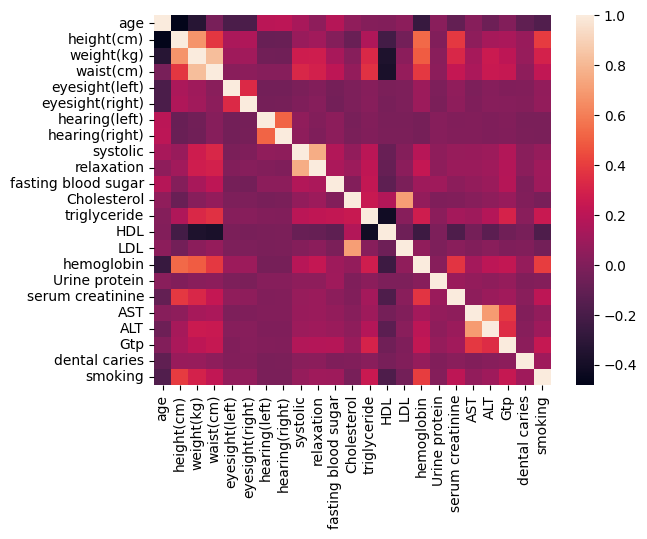

In [ ]:
import matplotlib.pyplot as plt
# Data Analysis
sns.heatmap(train_df.corr(numeric_only=True))
plt.show()

In [ ]:
train_df.corr(numeric_only=True)['smoking']

,smoking
age,-0.166268
height(cm),0.394314
weight(kg),0.299347
waist(cm),0.223359
eyesight(left),0.059409
eyesight(right),0.064587
hearing(left),-0.022077
hearing(right),-0.018990
systolic,0.070176
relaxation,0.103663


The Height,weight and waist show positive correlation with soking columns.
The 3 columns of eyesight,hearing and dental carries show correlation near to 0 with target.
Few columns shows lower correlation , but have interaction with other columns.

Univariate Analysis

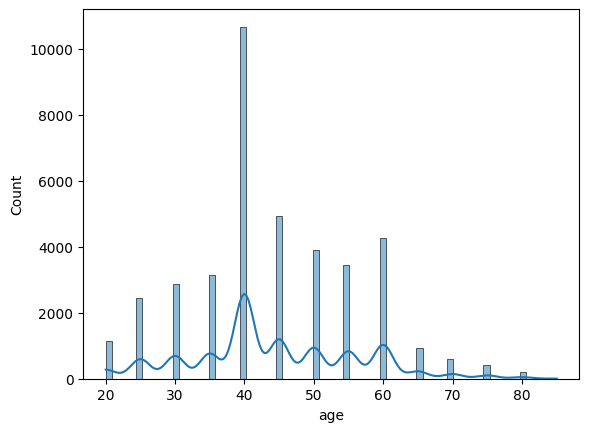

In [ ]:
sns.histplot(data=train_df,x='age',kde=True)
plt.show()

Here the data looks concentrated near the range 35-45 age range

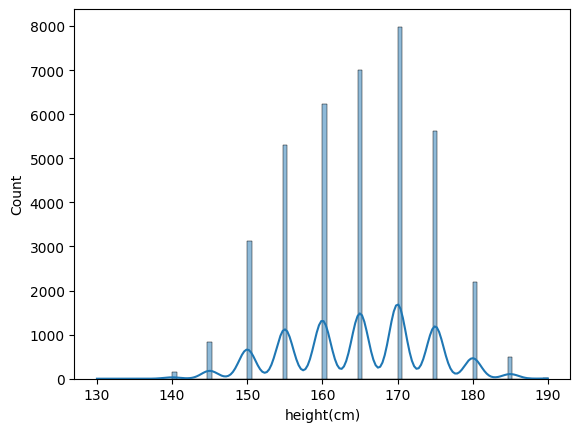

In [ ]:
sns.histplot(data=train_df,x='height(cm)',kde=True)
plt.show()

The histplot for height(cm) shows a multimodal distribution, meaning there are several distinct peaks. This suggests that there might be different subgroups within the dataset with varying average heights, such as different genders or age groups. The distribution is roughly centered around 165 cm, as indicated by the mean and median, with heights ranging from 130 cm to 190 cm.

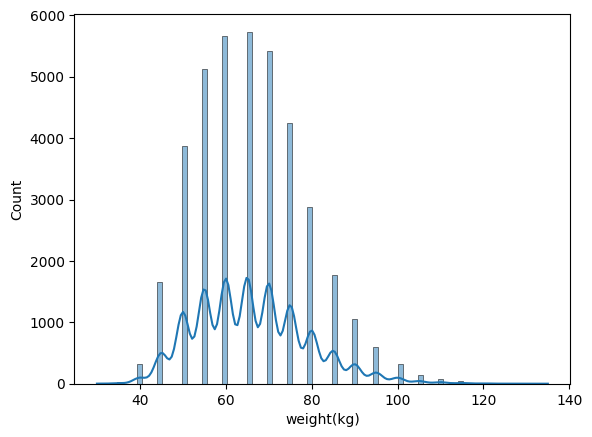

In [ ]:


sns.histplot(data=train_df,x='weight(kg)',kde=True)
plt.show()


The KDE curve is multimodal, meaning it has several distinct peaks (local maximums). It appears to have three or four major peaks, such as around 55 kg, 65 kg, 75 kg, and possibly 85 kg.

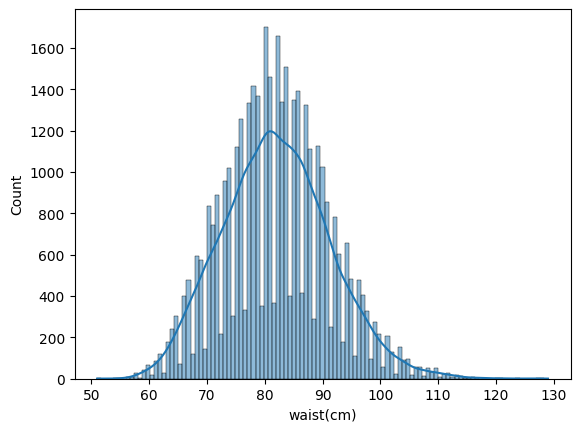

In [ ]:
#waist
sns.histplot(data=train_df,x='waist(cm)',kde=True)
plt.show()

Waist seems to be normal distribution data slightly skewed right mean is around 80

Men >94 cm (37 inches)[Increased Risk],>102 cm (40 inches)[Risky]

Women >80 cm (31.5 inches)[Increased Risk],>88 cm (34.6 inches)[Risky]

This shows obesity chances among people in the data.

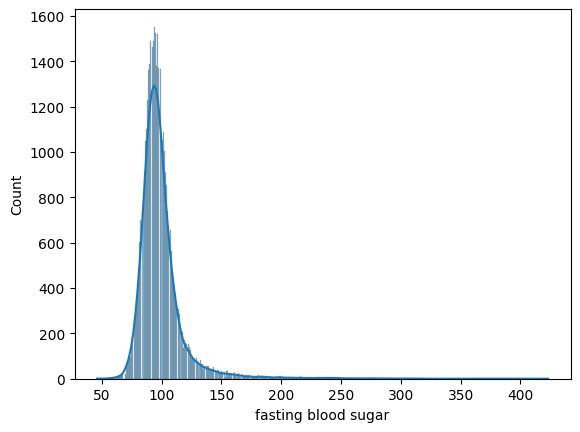

In [ ]:
#Analysing Fasting Blood Sugar Value: Seems to affect most of the smoking individuals as per domain
#data seen
sns.histplot(data=train_df,x='fasting blood sugar',kde=True)
plt.show()

The blood sugar is integer, though its not categorical. but seems like a right skewed normal distribution case and mean value aroung 100 and highs to be 68.6% range falls between >70 and < 120 range Most of the show normal sugar ranges

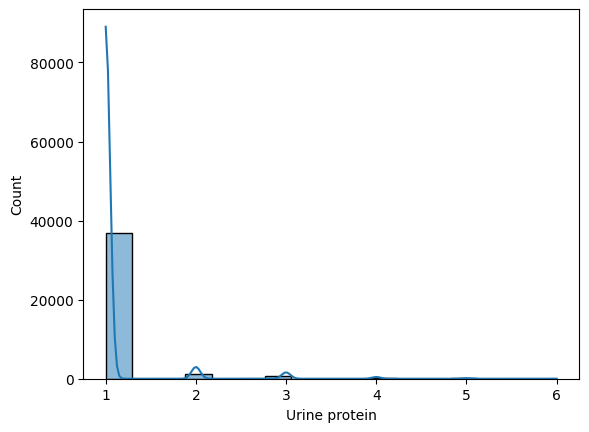

In [ ]:
#analysing urine creatinine , smoking seems to affect kidneys
#it is categorical
sns.histplot(data=train_df,x='Urine protein',kde=True)
plt.show()


The dataset suggests that the population largely exhibits normal kidney function, with only a small fraction showing elevated protein levels.

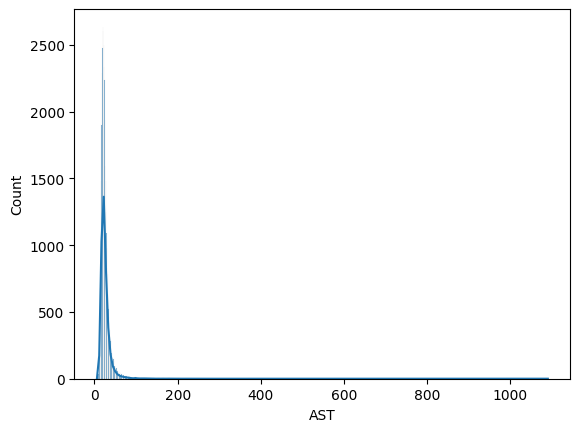

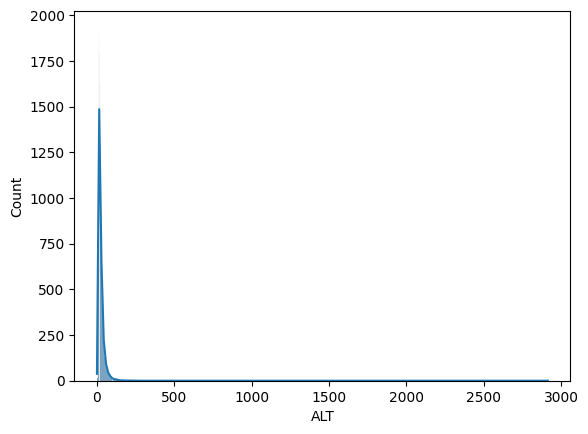

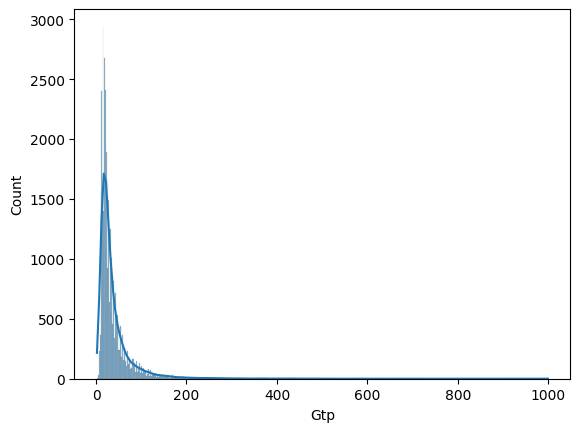

In [ ]:
#ALT AST GPT:
#These are liver enzymes
l=['AST','ALT', 'Gtp']
for i in l:
  sns.histplot(data=train_df,x=i,kde=True)
  plt.show()


Mostly Similar to Normal Dist(Right Skewed) Helpful if we watch these columns with bivariate analysis

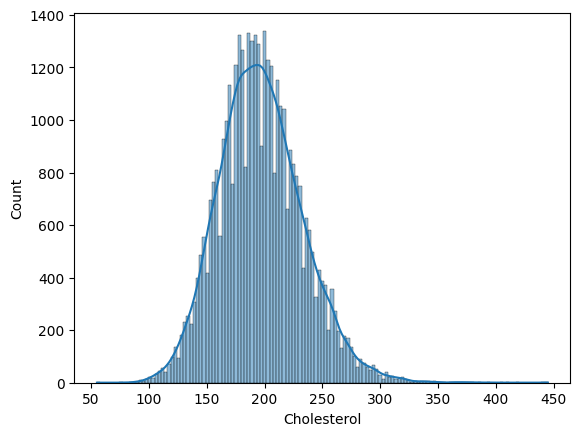

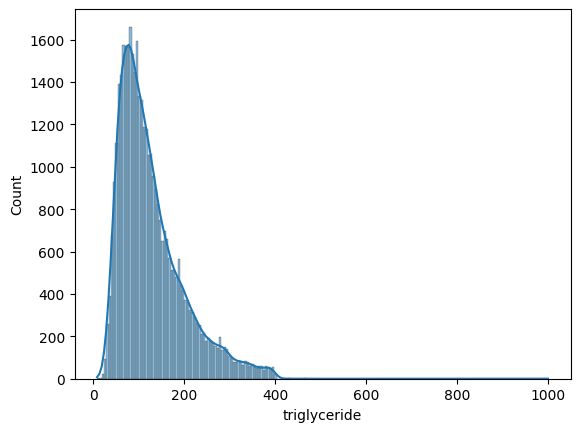

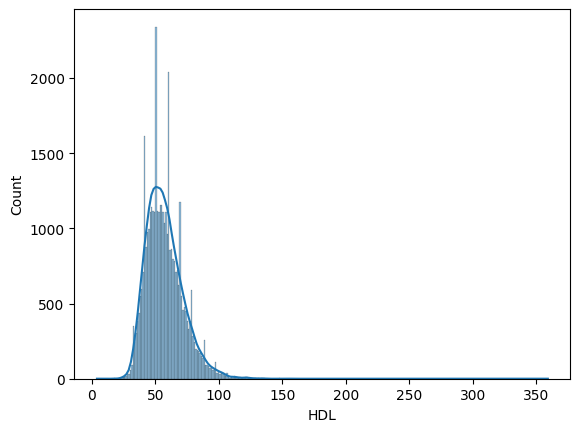

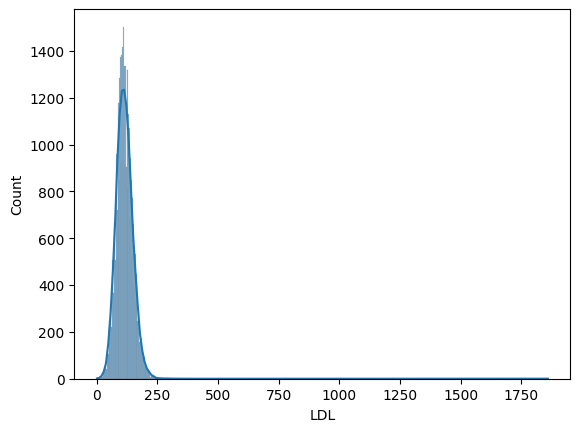

In [ ]:
l=['Cholesterol', 'triglyceride','HDL', 'LDL',]
for i in l:
  sns.histplot(data=train_df,x=i,kde=True)
  plt.show()

Values are from Normal Distribution, but more insights can be given with other factors, Bivariate analysis

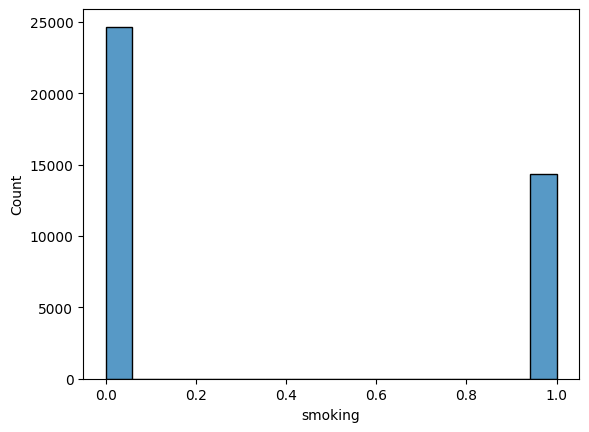

In [ ]:
sns.histplot(data=train_df,x='smoking')
plt.show()


Count shows class imbalance of more 0 values than 1's

Bivariate Analysis

Weight v/s Waist

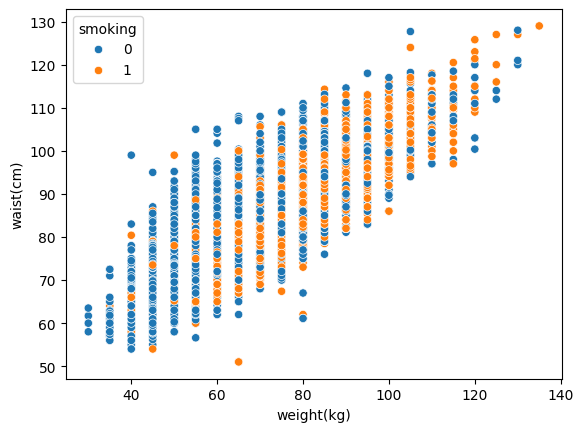

In [ ]:
sns.scatterplot(data=train_df,x='weight(kg)',y='waist(cm)',hue='smoking')
plt.show()

There is subgroups formed between weight and waist formed, clearly visible from plot and Obesity seems increasing in smoking category

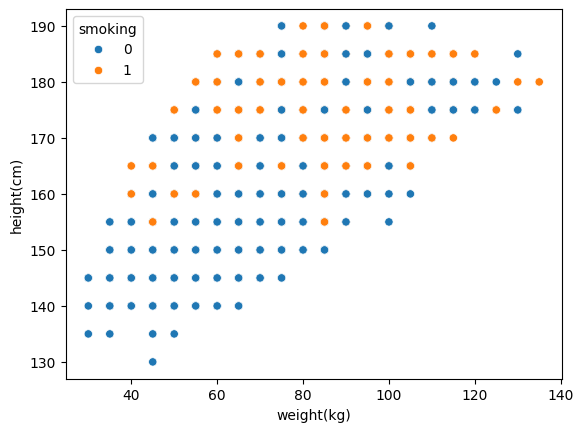

In [ ]:
sns.scatterplot(data=train_df,x='weight(kg)',y='height(cm)',hue='smoking')
plt.show()


Linear relationship between height and weight exists

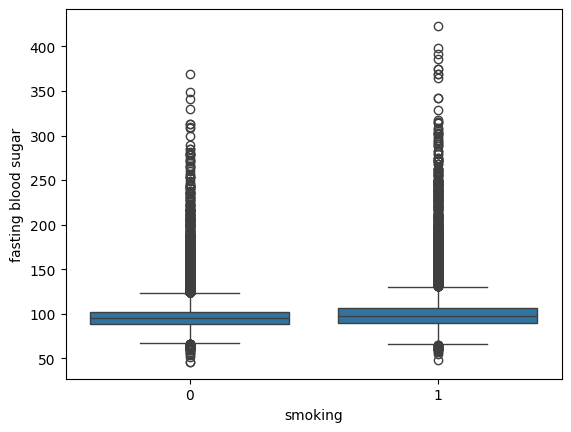

In [ ]:
sns.boxplot(data=train_df,x='smoking',y='fasting blood sugar')
plt.show()

blood sugar seems slightly elevated in smoking range

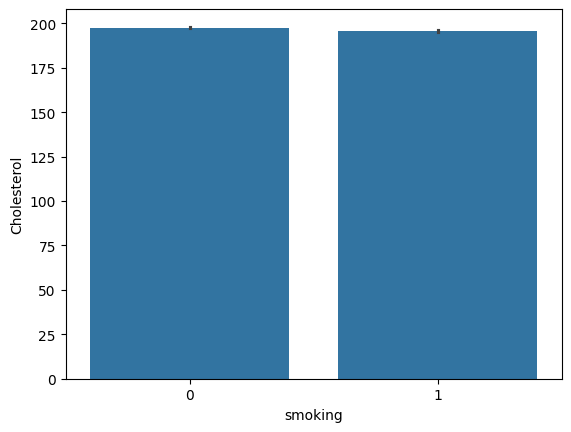

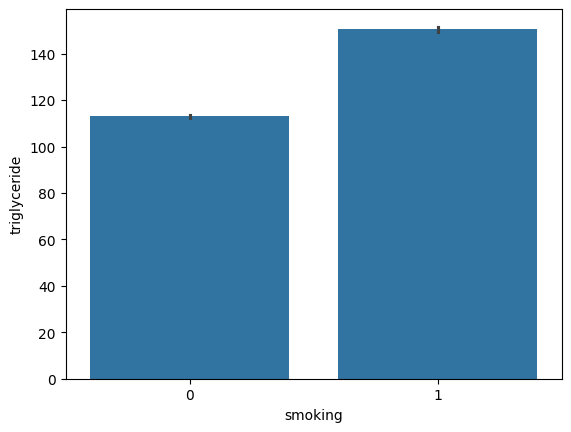

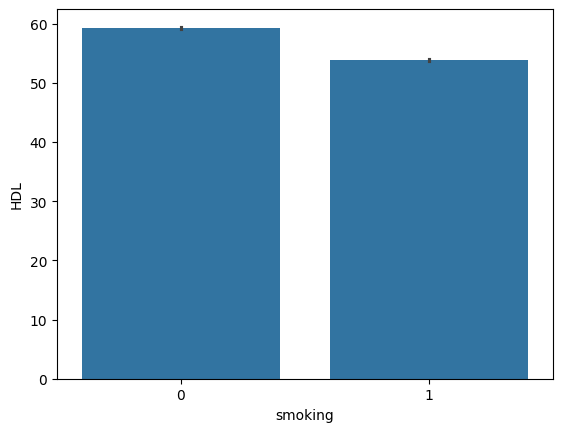

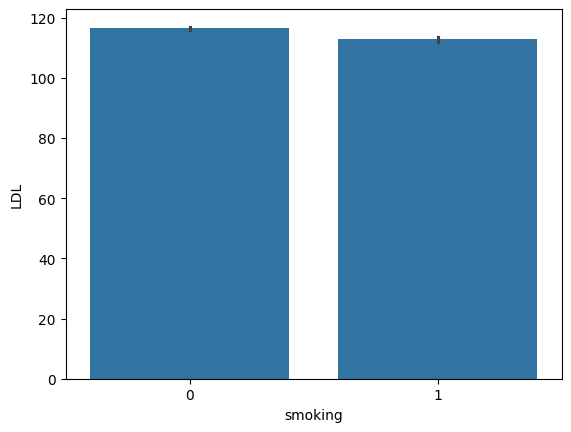

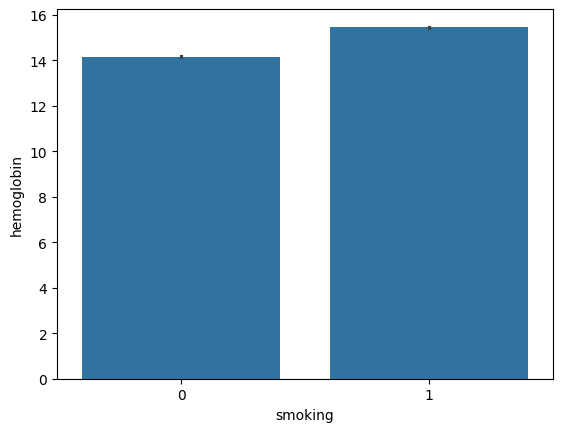

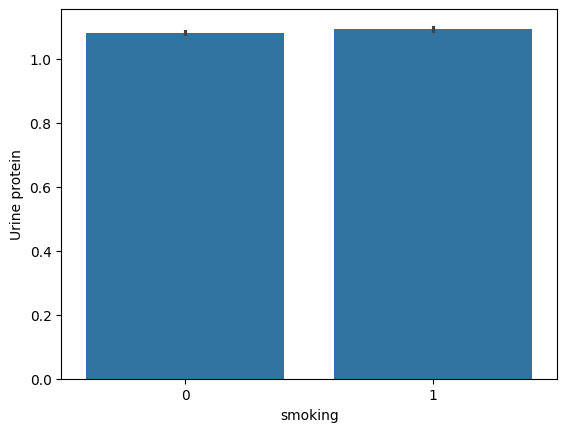

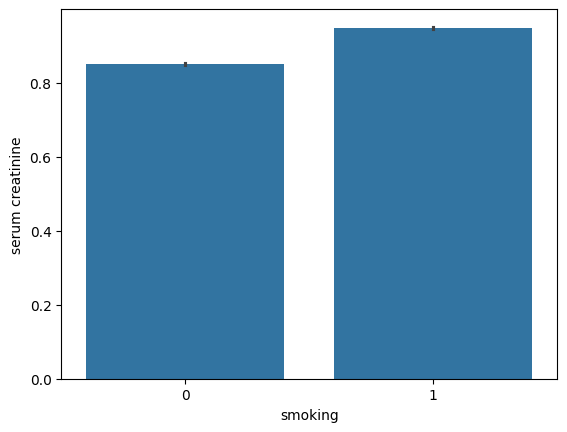

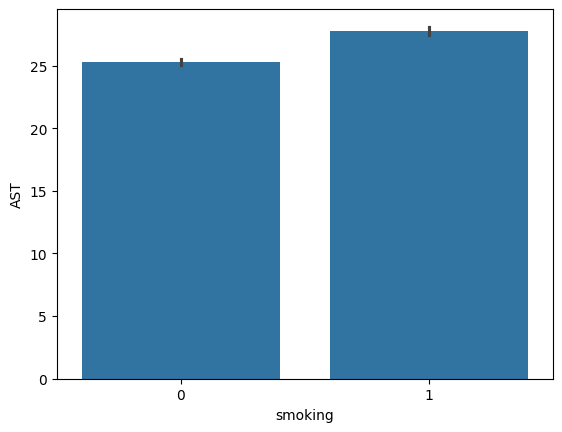

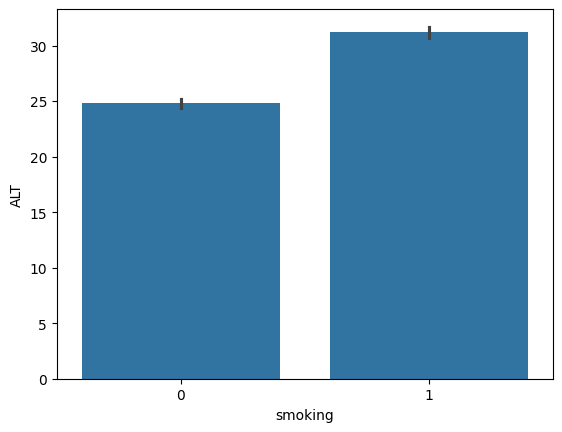

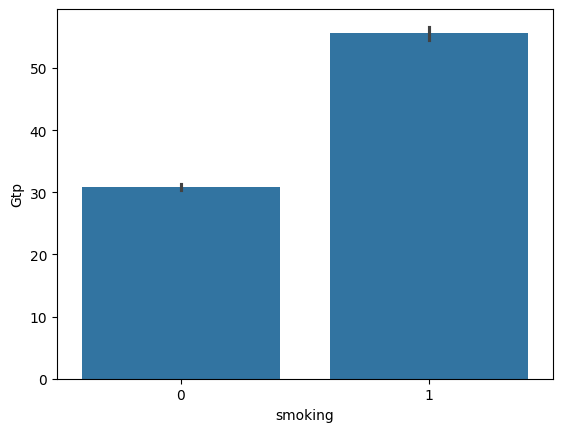

In [ ]:
l=['Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp']
for i in l:
  sns.barplot(data=train_df,x='smoking',y=i)
  plt.show()


Average values for each category of smoking is shown in the following plots:

Cholestrol: Seems similar to average values, and can be true since cholestrol values also depend on food habits
Triglyceride: Seems to be elevated in smoking category
LDL and HDL : Seems more in non smokers, could have been affected by class imbalance
Serum Creatinine and Urine Protein : Seems elevated or slightly elevated in smokers
AST,ALT,GPT shows clear risk of fatty liver disease in smokers
Haemoglobin values: Seems slightly elevated in smokers, haemoglobin (Hb) levels often increase in smokers, a condition known as secondary polycythemia or erythrocytosis.

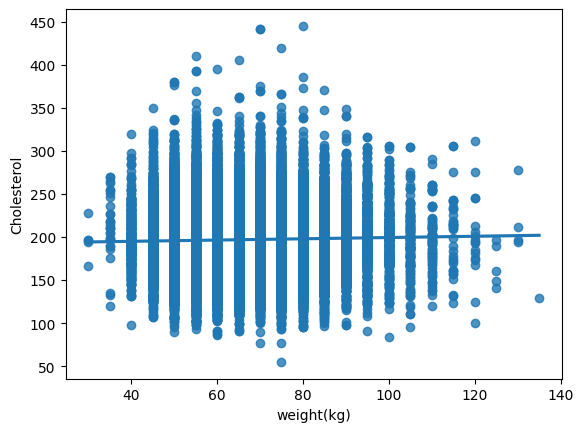

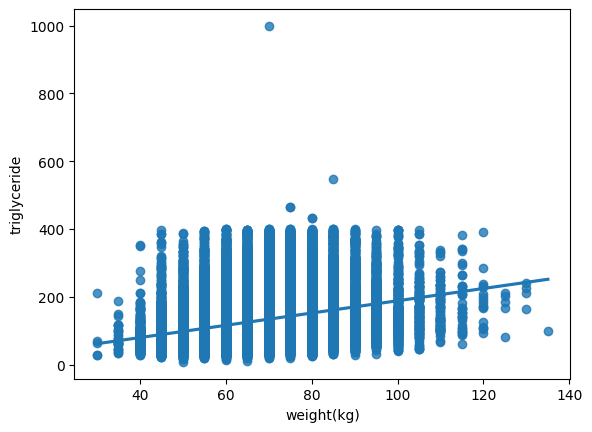

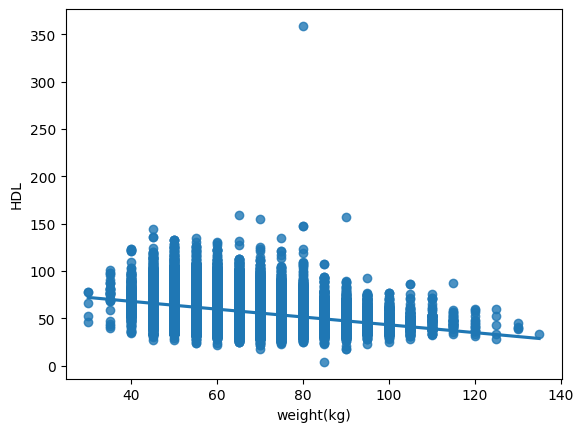

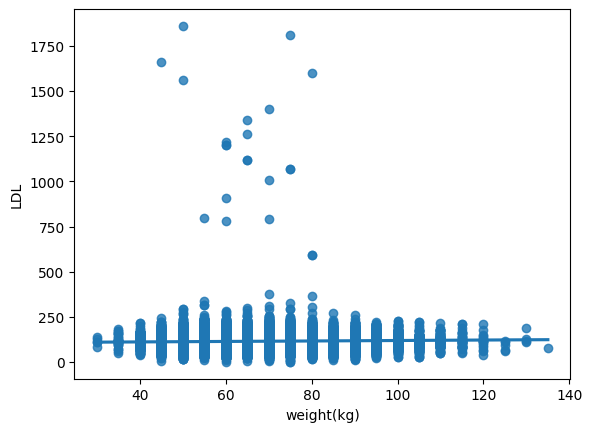

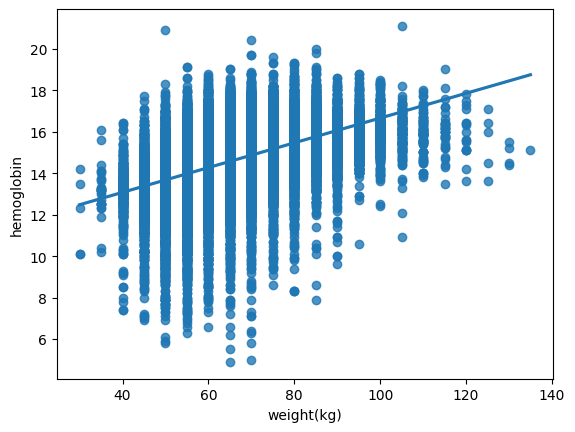

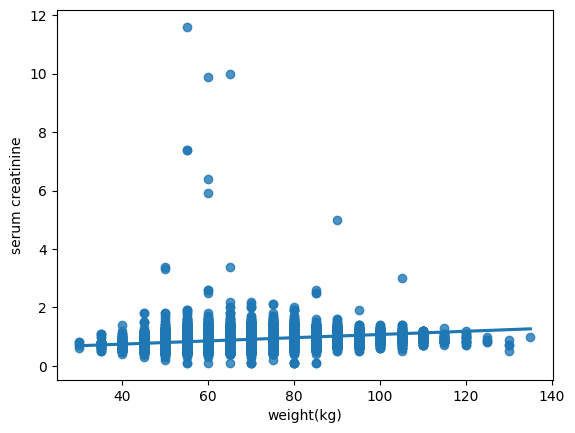

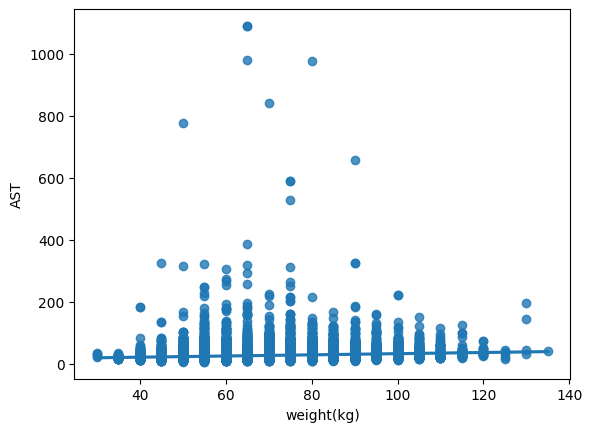

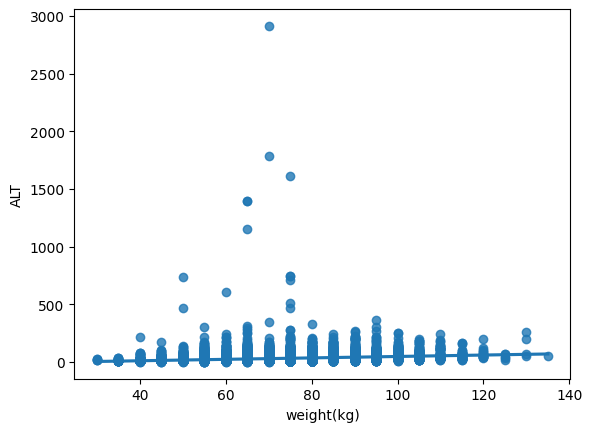

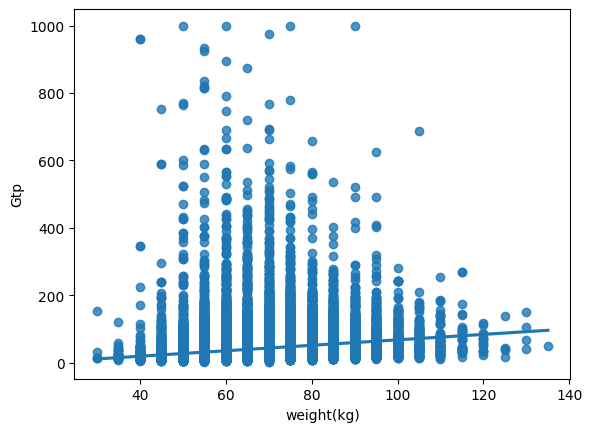

In [ ]:

l=['Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin','serum creatinine', 'AST',
       'ALT', 'Gtp']
for i in l:
  sns.regplot(data=train_df,x='weight(kg)',y=i)
  plt.show()


The Liver Enzymes AST,GPT,ALT ,Serum Creatinine, triglyceride elevated as weight proceeds
The HDL decreased and LDL increased with weight
The behaviour of haemoglobin shows slight increase,which can be due to inflamation or body composition

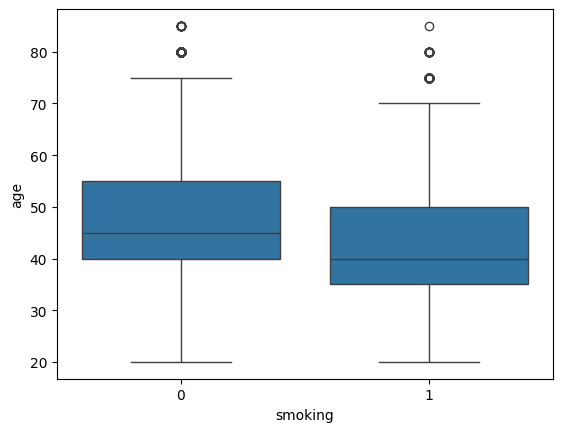

In [ ]:
sns.boxplot(data=train_df,x='smoking',y='age')
plt.show()


Range of age of smokers: 35 to 55,High at 70 , low at 20

And the Range of non smokers in data: 40 to 58

In [ ]:
train_df.columns


Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

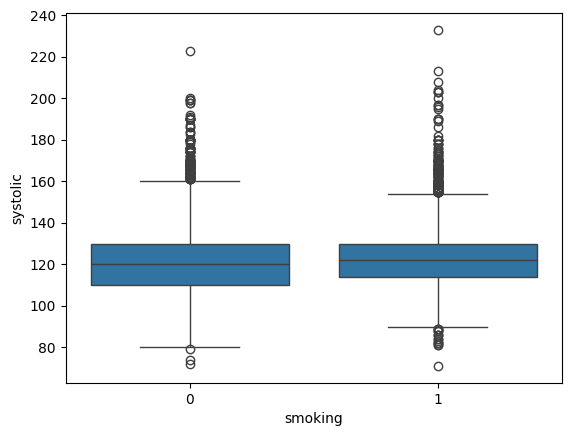

In [ ]:
sns.boxplot(data=train_df,x='smoking',y='systolic')
plt.show()


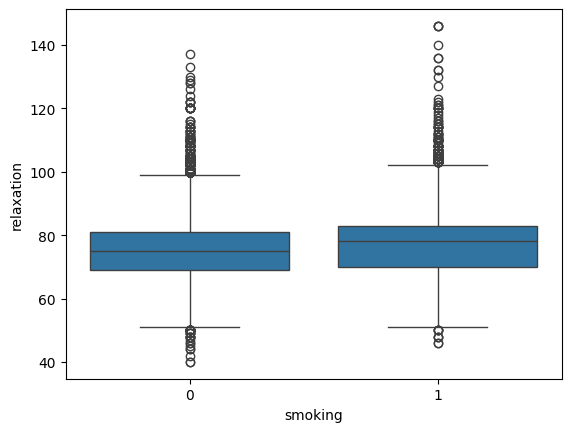

In [ ]:
sns.boxplot(data=train_df,x='smoking',y='relaxation')
plt.show()


The range of BP in both cases have average slightly shifted upwards in smokers category

3D Analysis

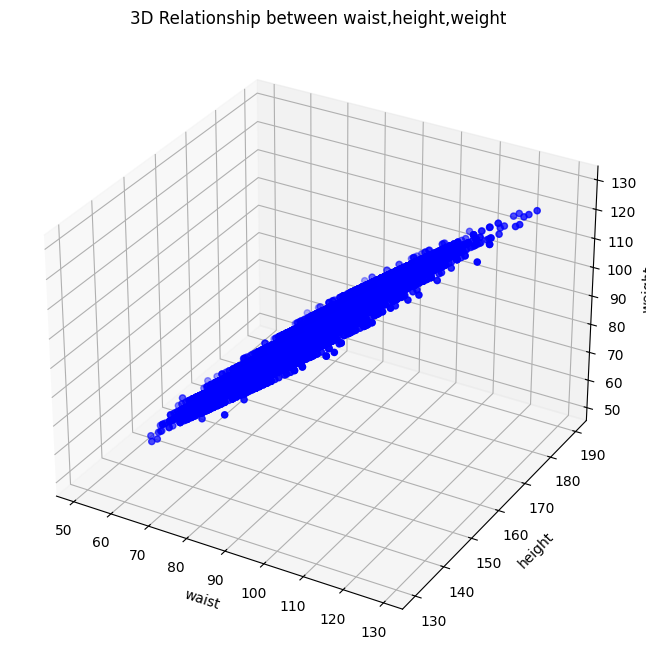

In [ ]:
#3d plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_df['waist(cm)'],train_df['height(cm)'],train_df['waist(cm)'], c='blue', marker='o')

ax.set_xlabel('waist')
ax.set_ylabel('height')
ax.set_zlabel('weight')
ax.set_title('3D Relationship between waist,height,weight')

plt.show()



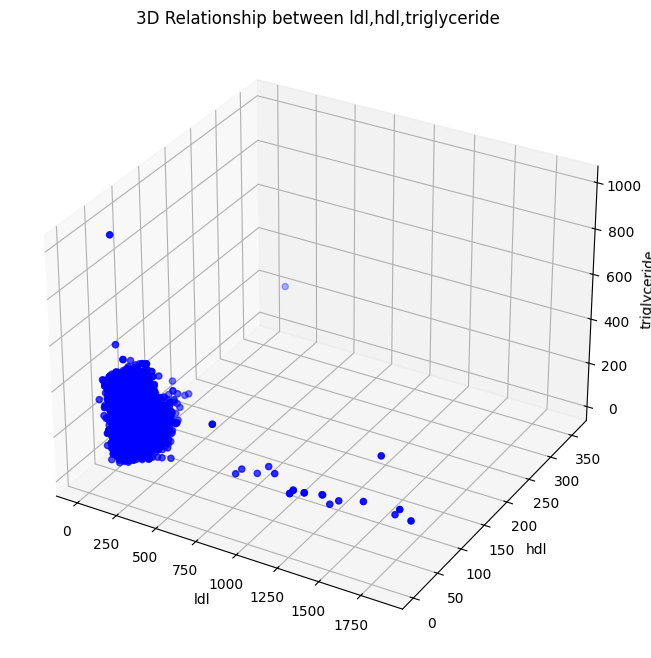

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_df['LDL'],train_df['HDL'],train_df['triglyceride'], c='blue', marker='o')

ax.set_xlabel('ldl')
ax.set_ylabel('hdl')
ax.set_zlabel('triglyceride')
ax.set_title('3D Relationship between ldl,hdl,triglyceride')

plt.show()


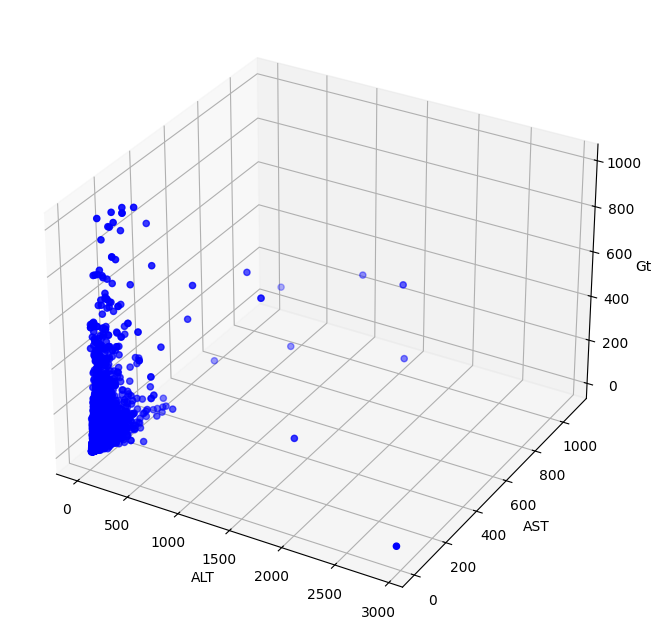

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_df['ALT'],train_df['AST'],train_df['Gtp'], c='blue', marker='o')

ax.set_xlabel('ALT')
ax.set_ylabel('AST')
ax.set_zlabel('Gtp')
plt.show()



No clear trivariate relationship exists
The eyesight,hearing and dental caries are effect of smoking many times.
But by domain are not major indicators of smoker effect.Hence these columns can be dropped
PCA can be performed to reduce dimensionality

**Data Preprocessing**

In [ ]:
# ---------------------------------------------------------
# 2. Preprocessing Logic
# ---------------------------------------------------------
def clean_and_prepare(train_df, test_df):
    target = 'smoking'

    # Drop ID if present
    if 'ID' in train_df.columns:
        train_df = train_df.drop(columns=['ID'])

    test_id = None
    if test_df is not None:
        if 'ID' in test_df.columns:
            test_id = test_df['ID']
            test_df = test_df.drop(columns=['ID'])

    # Separate X and y for training
    X_train_raw = train_df.drop(columns=[target])
    y_train = train_df[target]

    # Handle Test Data
    if test_df is not None:
        if target in test_df.columns:
            X_test_raw = test_df.drop(columns=[target])
            y_test = test_df[target]
        else:
            X_test_raw = test_df
            y_test = None
    else:
        X_test_raw = None
        y_test = None

    # Define Column Types
    categorical_cols = ['hearing(left)', 'hearing(right)', 'dental caries', 'Urine protein']
    # Ensure categorical columns exist before filtering
    categorical_cols = [c for c in categorical_cols if c in X_train_raw.columns]
    numerical_cols = [col for col in X_train_raw.columns if col not in categorical_cols]

    # --- Outlier Handling (Fit on Train, Apply to both) ---
    for col in numerical_cols:
        lower = X_train_raw[col].quantile(0.01)
        upper = X_train_raw[col].quantile(0.99)
        X_train_raw[col] = np.clip(X_train_raw[col], lower, upper)
        if X_test_raw is not None:
            X_test_raw[col] = np.clip(X_test_raw[col], lower, upper)

    # --- Pipeline Construction ---
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipeline, numerical_cols),
        ('cat', cat_pipeline, categorical_cols)
    ])

    print("Fitting preprocessor...")
    X_train_processed = preprocessor.fit_transform(X_train_raw)

    if X_test_raw is not None:
        X_test_processed = preprocessor.transform(X_test_raw)
    else:
        X_test_processed = None

    return X_train_processed, y_train, X_test_processed, y_test, test_id

**Model Training and Evaluation**

In [ ]:
# ---------------------------------------------------------
# 3. Logistic Regression with RandomizedSearchCV
# ---------------------------------------------------------
def train_logreg_randomized(X_train, y_train, X_test=None, y_test=None):
    print("\n--- Tuning Logistic Regression with RandomizedSearchCV ---")

    # Split for internal validation during search
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

    param_dist = {
        'C': np.logspace(-3, 2, 20),
        'solver': ['liblinear', 'lbfgs'],
        'class_weight': [None, 'balanced']
    }

    logreg = LogisticRegression(max_iter=2000, random_state=42)

    # Randomized Search
    random_search = RandomizedSearchCV(
        estimator=logreg,
        param_distributions=param_dist,
        n_iter=15,
        cv=3,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    random_search.fit(X_tr, y_tr)
    best_model = random_search.best_estimator_

    print(f"Best LogReg Params: {random_search.best_params_}")
    print(f"Best CV Score: {random_search.best_score_:.4f}")

    # Validation Evaluation
    val_preds = best_model.predict(X_val)
    print("Validation Classification Report:\n", classification_report(y_val, val_preds))

    return best_model

In [ ]:
# ---------------------------------------------------------
# 4. Neural Network with Optuna Tuning
# ---------------------------------------------------------
def objective_nn(trial, X_train, y_train, X_val, y_val):
    # Hyperparameters to tune (Updated as per request)
    n_layers = trial.suggest_int('n_layers', 1, 10)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    model = Sequential()
    input_dim = X_train.shape[1]

    for i in range(n_layers):
        units = trial.suggest_int(f'units_l{i}', 16, 256, step=32)
        dropout_rate = trial.suggest_float(f'dropout_l{i}', 0.01, 0.5)

        if i == 0:
            model.add(Dense(units, input_dim=input_dim, activation='relu', kernel_initializer='he_normal'))
        else:
            model.add(Dense(units, activation='relu', kernel_initializer='he_normal'))

        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Early stopping for the trial
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    if 'val_accuracy' in history.history and len(history.history['val_accuracy']) > 0:
        val_acc = max(history.history['val_accuracy'])
    else:
        val_acc = 0.0

    return val_acc

def train_nn_optuna(X_train_full, y_train_full, X_test=None, y_test=None, n_trials=10):
    print("\n--- Tuning Neural Network with Optuna ---")

    # Split training data for Optuna validation (80% of the input for training, 20% for tuning validation)
    X_tr, X_val, y_tr, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective_nn(trial, X_tr, y_tr, X_val, y_val), n_trials=n_trials)

    print("Best NN Trial:")
    print(study.best_trial.params)

    # Retrain best model on full training data (X_tr + X_val) with best params
    best_params = study.best_params

    # Rebuild Model using the dynamic best_params
    model = Sequential()
    input_dim = X_train_full.shape[1]

    n_layers = best_params['n_layers']
    for i in range(n_layers):
        units = best_params[f'units_l{i}']
        dropout = best_params[f'dropout_l{i}']

        if i == 0:
            model.add(Dense(units, input_dim=input_dim, activation='relu', kernel_initializer='he_normal'))
        else:
            model.add(Dense(units, activation='relu', kernel_initializer='he_normal'))

        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=best_params['lr'])
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    print("\nTraining final NN model with best parameters...")
    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=best_params['batch_size'],
        callbacks=[early_stop],
        verbose=1
    )

    return model, history

In [ ]:
# ---------------------------------------------------------
# 5. SVM with RandomizedSearchCV
# ---------------------------------------------------------
def train_svm_randomized(X_train, y_train):
    print("\n--- Tuning SVM with RandomizedSearchCV ---")

    # Using a subset for SVM tuning if dataset is very large (>20k rows) to save time
    if len(X_train) > 20000:
        print("Subsampling data for SVM tuning speed...")
        X_tr_sub, _, y_tr_sub, _ = train_test_split(X_train, y_train, train_size=10000, stratify=y_train, random_state=42)
    else:
        X_tr_sub, y_tr_sub = X_train, y_train

    param_dist = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf']
    }

    svm = SVC(probability=True, random_state=42)

    random_search = RandomizedSearchCV(
        estimator=svm,
        param_distributions=param_dist,
        n_iter=5, # Keep low for SVM as it is slow
        cv=3,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    random_search.fit(X_tr_sub, y_tr_sub)

    print(f"Best SVM Params: {random_search.best_params_}")

    # Return best estimator (trained on subset is faster)
    # If you want maximum accuracy, you can refit on full data, but it is slow.
    best_svm = random_search.best_estimator_

    print("Refitting best SVM on full training data...")
    best_svm.fit(X_train, y_train)

    return best_svm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report

Loaded Train shape: (38984, 23)
Loaded Test shape: (16708, 22)
Total samples loaded: 38984
Training+Validation pool size: 35085 (90%)
Holdout Test set size:         3899 (10%)
Fitting preprocessor...


[I 2025-12-11 14:32:34,591] A new study created in memory with name: no-name-9a02bfa7-3e03-4a35-b70c-a5d9fd8d8c79



--- Tuning Neural Network with Optuna ---


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [16, 256] and step=32, but the range is not divisible by `step`. It will be replaced with [16, 240].
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-12-11 14:33:34,940] Trial 0 finished with value: 0.7528858780860901 and parameters: {'n_layers': 4, 'lr': 0.0010364914877086862, 'batch_size': 64, 'units_l0': 48, 'dropout_l0': 0.4693046570111511, 'units_l1': 144, 'dropout_l1': 0.13976751614300606, 'units_l2': 144, 'dropout_l2': 0.4297634467401826, 'units_l3': 112, 'dropout_l3': 0.19371014421787758}. Best is trial 0 with value: 0.7528858780860901.
[I 2025-12-11 14:38:03,866]

Best NN Trial:
{'n_layers': 9, 'lr': 0.002984315406953304, 'batch_size': 64, 'units_l0': 144, 'dropout_l0': 0.44348375067276224, 'units_l1': 144, 'dropout_l1': 0.0224662625517417, 'units_l2': 144, 'dropout_l2': 0.34863668789953767, 'units_l3': 208, 'dropout_l3': 0.3574908284139759, 'units_l4': 112, 'dropout_l4': 0.47511235698453275, 'units_l5': 80, 'dropout_l5': 0.11486776575526021, 'units_l6': 176, 'dropout_l6': 0.1445542890879133, 'units_l7': 144, 'dropout_l7': 0.44190319433840697, 'units_l8': 176, 'dropout_l8': 0.4339455835574803}

Training final NN model with best parameters...
Epoch 1/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6133 - loss: 0.7044 - val_accuracy: 0.7311 - val_loss: 0.4956
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7062 - loss: 0.5268 - val_accuracy: 0.7364 - val_loss: 0.4868
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7328 - loss: 0.5052 - val_accuracy: 0.7416 - val_loss: 0.4787
Epoch 4/50
439/439 ━━━━

/tmp/ipython-input-2609258849.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='viridis')


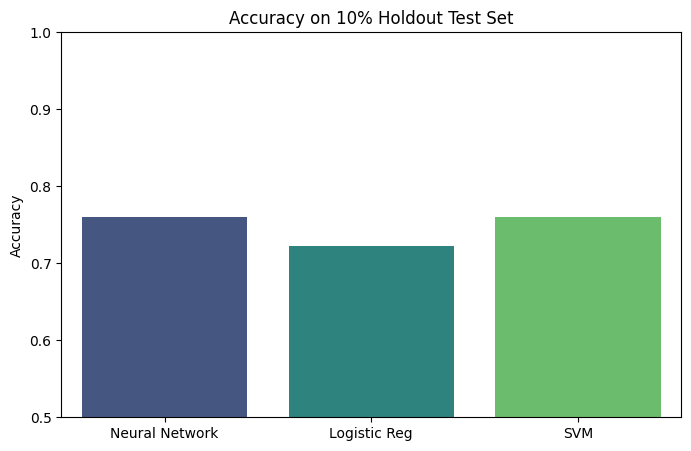

In [ ]:
# ---------------------------------------------------------
# 6. Main Execution
# ---------------------------------------------------------
if __name__ == "__main__":
    # 1. Load Data
    train_df_full, _ = load_data()

    if train_df_full is not None:
        print(f"Total samples loaded: {len(train_df_full)}")

        # -------------------------------------------------------------------------
        # SPLIT STRATEGY: 80% Train, 10% Validation, 10% Test
        # -------------------------------------------------------------------------
        # Step 1: Set aside 10% for Final Testing (Holdout)
        # The remaining 90% is 'train_val_df'
        train_val_df, test_split_df = train_test_split(
            train_df_full,
            test_size=0.10,
            random_state=42,
            stratify=train_df_full['smoking']
        )

        print(f"Training+Validation pool size: {len(train_val_df)} (90%)")
        print(f"Holdout Test set size:         {len(test_split_df)} (10%)")

        # Note: The training functions will internally use roughly 20% of 'train_val_df'
        # for validation, satisfying the 10% global validation requirement effectively.

        # 2. Preprocessing
        # Pass the 90% pool as 'train' and the 10% holdout as 'test'
        X_train, y_train, X_test, y_test, test_ids = clean_and_prepare(train_val_df, test_split_df)

        # ---------------------------
        # A. Neural Network (Optuna)
        # ---------------------------
        nn_model, nn_history = train_nn_optuna(X_train, y_train, X_test, y_test, n_trials=10)

        if X_test is not None:
            nn_pred_prob = nn_model.predict(X_test).ravel()
            nn_pred_class = (nn_pred_prob >= 0.5).astype(int)
        else:
            nn_pred_prob, nn_pred_class = None, None

        # ---------------------------
        # B. Logistic Regression (RandomizedSearch)
        # ---------------------------
        log_model = train_logreg_randomized(X_train, y_train)

        if X_test is not None:
            log_pred_class = log_model.predict(X_test)
            log_pred_prob = log_model.predict_proba(X_test)[:, 1]
        else:
            log_pred_class, log_pred_prob = None, None

        # ---------------------------
        # C. SVM (RandomizedSearch)
        # ---------------------------
        svm_model = train_svm_randomized(X_train, y_train)

        if X_test is not None:
            svm_pred_class = svm_model.predict(X_test)
        else:
            svm_pred_class = None

        # ---------------------------
        # 7. Results Consolidation & Export
        # ---------------------------
        results_df = pd.DataFrame()

        # If ID column existed in the split, preserve it
        if test_ids is not None:
            results_df['ID'] = test_ids.values

        # Save actual values for comparison
        if y_test is not None:
            results_df['Actual_Smoking'] = y_test.values

        if nn_pred_class is not None:
            results_df['NN_Prob'] = nn_pred_prob
            results_df['NN_Pred'] = nn_pred_class

        if log_pred_class is not None:
            results_df['LogReg_Prob'] = log_pred_prob
            results_df['LogReg_Pred'] = log_pred_class

        if svm_pred_class is not None:
            results_df['SVM_Pred'] = svm_pred_class

        if not results_df.empty:
            results_df.to_csv('optimized_model_results_split.csv', index=False)
            print("\nPredictions on Holdout Test Set saved to 'optimized_model_results_split.csv'")
            print(results_df.head())

        # Final Accuracy Comparison on the 10% Test Set
        if y_test is not None:
            print("\n--- Final Model Comparison (Accuracy on 10% Test Set) ---")
            print(f"Neural Network: {accuracy_score(y_test, nn_pred_class):.4f}")
            print(f"Logistic Reg:   {accuracy_score(y_test, log_pred_class):.4f}")
            print(f"SVM:            {accuracy_score(y_test, svm_pred_class):.4f}")

            # Plot Comparison
            model_names = ['Neural Network', 'Logistic Reg', 'SVM']
            accuracies = [
                accuracy_score(y_test, nn_pred_class),
                accuracy_score(y_test, log_pred_class),
                accuracy_score(y_test, svm_pred_class)
            ]
            plt.figure(figsize=(8, 5))
            sns.barplot(x=model_names, y=accuracies, palette='viridis')
            plt.ylim(0.5, 1.0)
            plt.ylabel('Accuracy')
            plt.title('Accuracy on 10% Holdout Test Set')
            plt.show()